# Data Preprocessing - (1) 결측치(NaN) 처리

In [20]:
import numpy as np
import pandas as pd

df = pd.read_csv('data/ozone.csv')
display(df)

training_data = df[['Ozone', 'Temp']] # Fancy Indexing
display(training_data.shape) # 2차원, (row 개수, column 개수) => (153, 2)

# 결측치(NaN) 처리 -> 삭제
training_data = training_data.dropna(how='any')
print(training_data.shape) # (116,2), 너무 많이 삭제되서 좋지 않은 방법

# 이상치(종속변수에서 이상한 값) 처리 -> 일단은 이상치가 없다고 가정하여 진행

print(type(training_data))
print(type(training_data.values))

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41.0,190.0,7.4,67,5,1
1,36.0,118.0,8.0,72,5,2
2,12.0,149.0,12.6,74,5,3
3,18.0,313.0,11.5,62,5,4
4,NaN,NaN,14.3,56,5,5
...,...,...,...,...,...,...
148,30.0,193.0,6.9,70,9,26
149,NaN,145.0,13.2,77,9,27
150,14.0,191.0,14.3,75,9,28
151,18.0,131.0,8.0,76,9,29


(153, 2)

(116, 2)
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


# Simple Linear Regression
-----
### 온도에 따른 오존량을 측정해보자.

## 1. Tensorflow

In [21]:
import tensorflow as tf

# 1. Training Data Set
x_data = training_data['Temp'].values.reshape(-1, 1)
# print(x_data)
t_data = training_data['Ozone'].values.reshape(-1, 1)

# 2. Data Flow Graph

# (2-1). placeholder - 데이터를 입력받는 파라미터
X = tf.placeholder(shape=[None, 1], dtype=tf.float32) # 1 - Simple Linear Regression
T = tf.placeholder(shape=[None, 1], dtype=tf.float32) # 1 - 단변량 Linear Regression

# (2-2). Weight, bias
W = tf.Variable(tf.random.normal([1, 1]), name='weight')
b = tf.Variable(tf.random.normal([1, 1]), name='bias')

# (2-3). Hypothesis = Predict Model
H = tf.matmul(X, W) + b

# (2-4). Loss Function
loss = tf.reduce_mean(tf.square(H - T))

# (2-5). Gradient Descent Algorithm -> W, b?
train = tf.train.GradientDescentOptimizer(learning_rate=1e-4).minimize(loss)

## 여기까지 그래프 완성

# 3. 반복 학습
sess = tf.Session() # session
sess.run(tf.global_variables_initializer()) # 초기화

for step in range(300000):
    _, W_val, b_val, loss_val = sess.run([train, W, b, loss], feed_dict={X: x_data, T: t_data})
    
    
    if step%30000 == 0:
        print('W: {}, b: {}, loss: {}'.format(W_val, b_val, loss_val))

W: [[0.9319085]], b: [[0.09064844]], loss: 16227.24609375
W: [[0.7223282]], b: [[-12.164594]], loss: 816.2138061523438
W: [[0.86445564]], b: [[-23.394936]], loss: 774.14013671875
W: [[0.9947318]], b: [[-33.68883]], loss: 738.7870483398438
W: [[1.1141671]], b: [[-43.126125]], loss: 709.0750122070312
W: [[1.2236686]], b: [[-51.778496]], loss: 684.1033325195312
W: [[1.3240353]], b: [[-59.709072]], loss: 663.1212768554688
W: [[1.4160032]], b: [[-66.976006]], loss: 645.49609375
W: [[1.5002662]], b: [[-73.634125]], loss: 630.6915283203125
W: [[1.5777038]], b: [[-79.75294]], loss: 618.2195434570312


### 학습이 종료되었는데, 손실함수가 0으로 떨어지지 않는다?
아래에서 이상치 처리 후 다시 확인해보자.

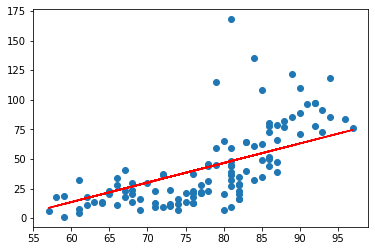

[[49.830246]]


In [22]:
import matplotlib.pyplot as plt

plt.scatter(x_data, t_data) # 온도, 오존량
plt.plot(x_data, x_data*W_val.ravel() + b_val, color='r')
plt.show()

# prediction
result = sess.run(H, feed_dict={X: [[82]]})
print(result) # [[46.586555]] -> 예측값이 맞는거야? 틀린거야?

## 2. Sklearn
Sklearn은 진리이므로 Sklearn을 이용해서 해당 data를 학습시키고 예측값 도출한 뒤, 위에서 Tensorflow를 통해 만든 Linear Model의 예측값과 비교해보자.

W: [[2.4287033]], b: [-146.99549097]
[[52.15818003]]


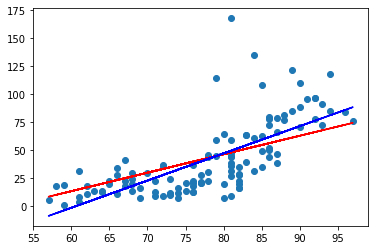

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model

# 1. Training Data Set
df = pd.read_csv('data/ozone.csv')
training_data = df[['Ozone', 'Temp']]
training_data = training_data.dropna(how='any')
x_data = training_data['Temp'].values.reshape(-1, 1)
t_data = training_data['Ozone'].values.reshape(-1, 1)

# 2. Linear Regression Model 생성
model = linear_model.LinearRegression()

# 3. 모델 학습
model.fit(x_data, t_data)

# 4. Weight, bias 출력
# (참고) tensorflow 구현 - W: [[0.56191754]], b: [[0.50884414]]
print('W: {}, b: {}'.format(model.coef_, model.intercept_)) # W: [[2.4287033]], b: [-146.99549097]


# 5. Prediction
print(model.predict([[82]])) # [[52.15818003]]

# 6. Visualization - Tensorflow vs. Sklearn
plt.scatter(x_data, t_data)
plt.plot(x_data, x_data*W_val.ravel() + b_val, color='r') # Tensorflow
plt.plot(x_data, x_data*model.coef_.ravel() + model.intercept_, color='b') # Sklearn (정답)
plt.show()

# Data Preprocessing - (2) 이상치(Outlier) 처리
-----

## 1. Tukey Fence

8.0
4.5
8.0
11.5
7.0
22.0
-6.0
[22.1]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


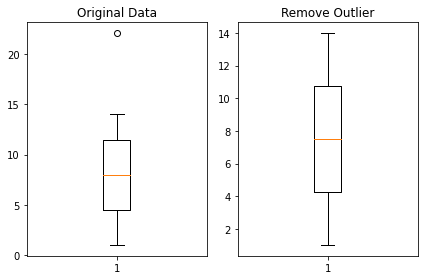

In [38]:
import numpy as np
import matplotlib.pyplot as plt

data = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,22.1])

# subplot
fig = plt.figure()  # 새로운 figure 생성 (도화지 준비)
fig_1 = fig.add_subplot(1,2, 1) # 영역_1: 1행 2열의, 첫번째 칸
fig_2 = fig.add_subplot(1,2, 2) # 영역_2: 1행 2열의, 두번째 칸


# percentile(): numpy를 이용해서 사분위수를 계산 
print(np.median(data)) # 중위값(2사분위): 8.0
print(np.percentile(data, 25)) # 1사분위: 4.5
print(np.percentile(data, 50)) # 2사분위: 8.0
print(np.percentile(data, 75)) # 3사분위: 11.5


# IQR value = 3사분위 값 - 1사분위 값
iqr_value = np.percentile(data, 75) - np.percentile(data, 25)
print(iqr_value) # 7.0


# 이상치
upper_fense = np.percentile(data, 75) + (iqr_value * 1.5)
lower_fense = np.percentile(data, 25) - (iqr_value * 1.5)

print(upper_fense) # 22.0
print(lower_fense) # -6.0


# 이상치 출력 - boolean indexing 이용
# (mask) | (mask)
print(data[(data > upper_fense) | (data < lower_fense)]) # [22.1]


# 이상치를 제거한 데이터
result = data[(data <= upper_fense) & (data >= lower_fense)]
print(result) 


# 비교
fig_1.set_title('Original Data')
fig_1.boxplot(data) 

fig_2.set_title('Remove Outlier')
fig_2.boxplot(result) 


# 출력
fig.tight_layout() # 레이아웃 예쁘게 잡아줌
plt.show() # 전체 figure 출력


## 2. Z-score

In [53]:
import numpy as np
from scipy import stats

# 2.0: optimal value
zscore_threshold = 1.8 # 상위 95% 이상, 하위 95% 이하인 값

data = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,22.1])

# data -> zscore
print(stats.zscore(data))

# oulier 출력
print(np.abs(stats.zscore(data)))  # 양수

outlier = data[np.abs(stats.zscore(data)) > zscore_threshold]
print(outlier)

# 이상치를 제거한 데이터 출력
np.isin(data, outlier) # data 안에 outlier 있니 -> Boolean Mask 반환
np.isin(data, outlier, invert=True) # not isin
print(data[np.isin(data, outlier, invert=True)])

[-1.40160702 -1.21405925 -1.02651147 -0.8389637  -0.65141593 -0.46386816
 -0.27632038 -0.08877261  0.09877516  0.28632293  0.4738707   0.66141848
  0.84896625  1.03651402  2.55565098]
[1.40160702 1.21405925 1.02651147 0.8389637  0.65141593 0.46386816
 0.27632038 0.08877261 0.09877516 0.28632293 0.4738707  0.66141848
 0.84896625 1.03651402 2.55565098]
[22.1]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


# 이상치 처리를 통한 Simple Linear Regression 구현
-----
* 결측치 제거
* 이상치 제거
* Tensorflow

## 들어가기 전,
### 1. 결측치 제거

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('data/ozone.csv')
df = df[['Temp', 'Ozone']]
display(df) # 153

df = df.dropna(how='any') 
display(df) # 116

,Temp,Ozone
0,67,41.0
1,72,36.0
2,74,12.0
3,62,18.0
4,56,NaN
...,...,...
148,70,30.0
149,77,NaN
150,75,14.0
151,76,18.0


,Temp,Ozone
0,67,41.0
1,72,36.0
2,74,12.0
3,62,18.0
5,66,28.0
...,...,...
147,63,14.0
148,70,30.0
150,75,14.0
151,76,18.0


### 2. boxplot을 통한 이상치 확인

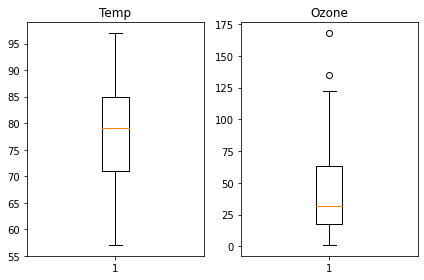

In [2]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig_1 = fig.add_subplot(1,2, 1)
fig_2 = fig.add_subplot(1,2, 2)

# Temp 이상치
fig_1.set_title('Temp')
fig_1.boxplot(df['Temp'])


# Ozone 이상치
fig_2.set_title('Ozone')
fig_2.boxplot(df['Ozone'])

fig.tight_layout()
plt.show()

이제 아래 두 가지 방법을 통해 이상치를 제거해보자.
## Tukey Fence
### 1. 이상치 제거

In [14]:
# IQR value
iqr_value = np.percentile(df['Ozone'], 75) - np.percentile(df['Ozone'], 25)
print(iqr_value)

# 이상치 확인
upper_fence = np.percentile(df['Ozone'], 75) + (iqr_value * 1.5)
lower_fence = np.percentile(df['Ozone'], 25) - (iqr_value * 1.5)

print(upper_fence)
print(lower_fence)
display(df[(df['Ozone'] > upper_fence) | (df['Ozone'] < lower_fence)])

# 이상치 제거
result = df[(df['Ozone'] <= upper_fence) & (df['Ozone'] >= lower_fence)]
display(result)

45.25
131.125
-49.875


,Temp,Ozone
61,84,135.0
116,81,168.0


,Temp,Ozone
0,67,41.0
1,72,36.0
2,74,12.0
3,62,18.0
5,66,28.0
...,...,...
147,63,14.0
148,70,30.0
150,75,14.0
151,76,18.0


### 2. Tensorflow

In [17]:
import tensorflow as tf

# 1. training data set
x_data = result['Temp'].values.reshape(-1,1)
t_data = result['Ozone'].values.reshape(-1,1)

# 2. X, T
X = tf.placeholder(shape=[None, 1], dtype=tf.float32)
T = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# 3. W, b
W = tf.Variable(tf.random.normal([1, 1]), name='weight')
b = tf.Variable(tf.random.normal([1, 1]), name='bias')

# 4. model
H = tf.matmul(X, W) + b

# 5. loss function
loss = tf.reduce_mean(tf.square(H - T))

# 6. gradient descent algorithm
train = tf.train.GradientDescentOptimizer(learning_rate=1e-4).minimize(loss)

# 7. learning
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(300000):
    _, W_val, b_val, loss_val = sess.run([train, W, b, loss], feed_dict={X: x_data, T: t_data})
    
    if step % 30000 == 0:
        print('W: {}, b: {}, loss: {}'.format(W_val, b_val, loss_val))

W: [[0.30977798]], b: [[1.8765798]], loss: 5887.5390625
W: [[0.67412645]], b: [[-10.289467]], loss: 638.6441040039062
W: [[0.8152366]], b: [[-21.430206]], loss: 597.2378540039062
W: [[0.9444343]], b: [[-31.630445]], loss: 562.5291137695312
W: [[1.0627074]], b: [[-40.96819]], loss: 533.4390258789062
W: [[1.1710194]], b: [[-49.519493]], loss: 509.049072265625
W: [[1.2701592]], b: [[-57.34664]], loss: 488.6103210449219
W: [[1.3609056]], b: [[-64.51112]], loss: 471.4820556640625
W: [[1.4440957]], b: [[-71.07903]], loss: 457.106689453125
W: [[1.5200673]], b: [[-77.07705]], loss: 445.0873718261719


[[47.780815]]


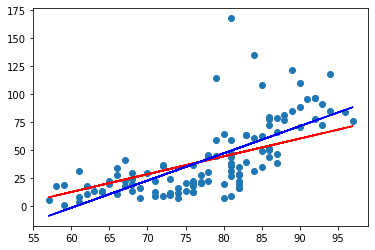

In [19]:
# 8. 예측
result = sess.run(H, feed_dict={X: [[82]]})
print(result) # [[47.780815]]

# 9. sklearn과 비교
plt.scatter(x_data, t_data)
plt.plot(x_data, x_data*W_val + b_val, color='r') # tensorflow
plt.plot(x_data, x_data*model.coef_.ravel() + model.intercept_, color='b') # sklearn
plt.show()

## Z-score
### 1. 이상치 제거

In [66]:
from scipy import stats

# 결측치 제거
data = pd.read_csv('data/ozone.csv')
data = data[['Temp', 'Ozone']]
data = data.dropna(how='any') 
display(data)

# zscore 변환
zscore_threshold = 1.8
zscore_data = stats.zscore(data['Ozone'])
print(zscore_data)

# 이상치 확인
zscore_abs = np.abs(zscore_data)
print(zscore_abs)
outlier = data['Ozone'][zscore_abs > zscore_threshold]
print(outlier)

# 이상치 제거
result = data[np.isin(data['Ozone'], outlier, invert=True)]
display(result)

,Temp,Ozone
0,67,41.0
1,72,36.0
2,74,12.0
3,62,18.0
5,66,28.0
...,...,...
147,63,14.0
148,70,30.0
150,75,14.0
151,76,18.0


[-0.03438262 -0.18661099 -0.91730719 -0.73463314 -0.43017639 -0.58240477
 -0.70418747 -1.0390899  -1.06953557 -0.79552449 -0.94775287 -0.85641584
 -0.73463314 -0.85641584 -0.24750234 -1.09998125 -0.36928504 -0.94775287
 -1.25220962 -0.94775287 -1.1608726  -0.30839369 -0.58240477  0.08740008
  2.21859734 -0.15616532 -0.39973072  0.87898764 -0.09527397 -0.58240477
 -0.64329612 -0.15616532 -0.67374179 -0.91730719 -0.88686152  2.82751085
  0.20918279 -0.30839369  0.66586791 -0.06482829  1.06166169  1.67057519
  1.67057519  1.30522709 -0.97819854 -0.46062207 -1.06953557  0.17873711
 -0.21705667  0.57453089  1.12255304  0.63542224 -0.79552449  1.15299871
  2.00547762 -0.67374179  0.30051981  1.21389006  0.23962846  0.66586791
  0.51363954 -0.09527397 -1.00864422 -0.79552449  1.09210736 -0.21705667
  0.72675926  2.43171707  1.42700979  2.06636897  0.05695441 -0.43017639
  0.69631359 -0.61285044  0.51363954 -0.58240477 -0.33883937  0.05695441
 -0.64329612 -1.00864422  0.08740008  3.83221813  0

,Temp,Ozone
0,67,41.0
1,72,36.0
2,74,12.0
3,62,18.0
5,66,28.0
...,...,...
147,63,14.0
148,70,30.0
150,75,14.0
151,76,18.0


### 2. Tensorflow 

In [69]:
import tensorflow as tf

# 1. training data set
x_data = result['Temp'].values.reshape(-1, 1)
t_data = result['Ozone'].values.reshape(-1, 1)

# 2. X, T
X = tf.placeholder(shape=[None, 1], dtype=tf.float32)
T = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# 3. W, b
W = tf.Variable(tf.random.normal([1, 1]), name='weight')
b = tf.Variable(tf.random.normal([1, 1]), name='bias')

# 4. model
H = tf.matmul(X, W) + b

# 5. loss function
loss = tf.reduce_mean(tf.square(H - T))

# 6. gradient descent algorithm
train = tf.train.GradientDescentOptimizer(learning_rate=1e-4).minimize(loss)

# 7. learning
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(300000):
    _, W_val, b_val, loss_val = sess.run([train, W, b, loss], feed_dict={X: x_data, T: t_data})
    if step % 30000 == 0:
        print('W: {}, b: {}, loss: {}'.format(W_val, b_val, loss_val))

W: [[0.885414]], b: [[2.1673093]], loss: 23051.962890625
W: [[0.6091627]], b: [[-8.603151]], loss: 461.25897216796875
W: [[0.7347729]], b: [[-18.463224]], loss: 428.8251037597656
W: [[0.8498253]], b: [[-27.494535]], loss: 401.61456298828125
W: [[0.9552083]], b: [[-35.766827]], loss: 378.7860412597656
W: [[1.0517409]], b: [[-43.34438]], loss: 359.6326904296875
W: [[1.1401317]], b: [[-50.28283]], loss: 343.5689392089844
W: [[1.221109]], b: [[-56.63933]], loss: 330.0894470214844
W: [[1.2952914]], b: [[-62.46246]], loss: 318.77911376953125
W: [[1.3632513]], b: [[-67.797134]], loss: 309.2887268066406


[[44.207626]]


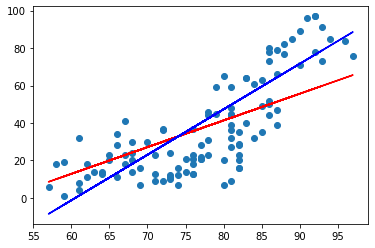

In [70]:
# 8. 예측
result = sess.run(H, feed_dict={X: [[82]]})
print(result) # [[44.207626]]

# 9. sklearn과 비교
plt.scatter(x_data, t_data)
plt.plot(x_data, x_data*W_val + b_val, color='r') # tensorflow
plt.plot(x_data, x_data*model.coef_.ravel() + model.intercept_, color='b') # sklearn
plt.show()